## Author: Dhyey Joshi

### Task - 07 : Stock Market Prediction using Numerical and Textual Analysis

### GRIP @ The Sparks Foundation

<p>In this task I tried to create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.</p>

### Technical Stack : Sikit Learn, Numpy Array, Pandas, Matplotlib,seaborn

<hr>

In [62]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24101 sha256=3bbe6653d803599e64b8227ff8f7421036e6c119e6c2e535caa4c4a5e1e6c1a2
  Stored in directory: C:\Users\Lenovo\AppData\Local\pip\Cache\wheels\79\06\23\8d21ef931f3c9e0420d3dc1fb45c25d6e58735c37df237f205
  Created wheel for multitasking: filename=multitasking-0.0.9-cp37-none-any.whl size=8373 sha256=0b48db0af25fbd59752bfd8ce4d83e66f96198d8847c2e1e67ecae697f8075b9
  Stored in directory: C:\Users\Lenovo\AppData\Local\pip\Cache\wheels\37\fa\73\d492849e319038eb4d986f5152e4b19ffb1bc0639da84d2677
Successfully built yfinance multitasking
  Found existing installation: lxml 4.4.1
    Uninstalling lxml-4.4.1:
      Successfully uninstalled lxml-4.4.1


In [164]:
!pip install vaderSentiment

In [165]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<hr>

### Step 1 : Importing the Numerical dataset and performing Exploratory Analysis

<h2> Yahoo! Finance market data downloader using API </h2>

* Ever since Yahoo! finance decommissioned their historical data API, many programs that relied on it to stop working.

* yfinance aims to solve this problem by offering a reliable, threaded, and Pythonic way to download historical market data from Yahoo! finance.

In [93]:
# Import yfinance package
import yfinance as yf

In [138]:
# Set the start and end date
start_date = '2020-01-01'
end_date = '2021-11-01'

# Set the ticker
ticker = 'AMZN'

# Get the data
df = yf.download(ticker, start_date, end_date)

# Print 5 rows
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-25,3335.000000,3347.800049,3297.699951,3320.370117,3320.370117,2226000
2021-10-26,3349.510010,3416.120117,3343.979980,3376.070068,3376.070068,2698300
2021-10-27,3388.000000,3437.000000,3371.449951,3392.489990,3392.489990,2702200
2021-10-28,3402.100098,3479.000000,3386.000000,3446.570068,3446.570068,5708700
2021-10-29,3300.020020,3374.820068,3273.320068,3372.429932,3372.429932,6469500


In [139]:
df = df.reset_index()

In [127]:
df.to_csv("YahooFinance_Sensex.csv")

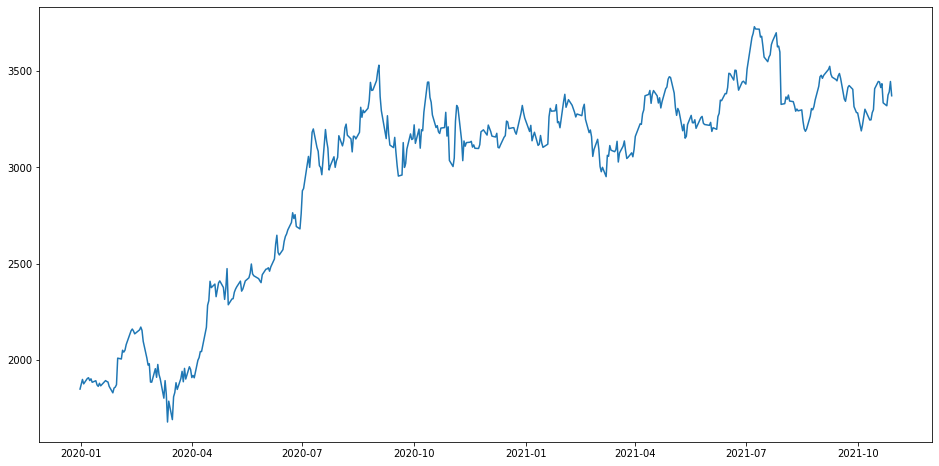

In [140]:
# Extract date frame and plot closing stock price w.r.t time
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df.dropna(inplace=True)
#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [141]:
# fix random seed for reproducibility
np.random.seed(7)

<hr>

### Step 2 : Creating a dataframe for storing the Closing stock data per day

> For Time Series Prediction With Deep Learning we require data per day basis. 


In [142]:
# convert an array of values into a dataset matrix
def create_dataset(df2, look_back=1):
    dataX, dataY = [], []
    for i in range(len(df2)-look_back-1):
        a = df2[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(df2[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [143]:
df2 = pd.read_csv('csv/YahooFinance_Sensex.csv', usecols=[5], engine='python')
df2.dropna(inplace=True)
df2 = df2.values
df2 = df2.astype('float32')

<hr>

### Step 3 : Data Normalization and Division into Training and Test sets

> I have used "Data Normalization" techniques such as MinMaxScaler, But we can also use StandardScaler ( Ranging down the values between 0 & 1)

In [144]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df2 = scaler.fit_transform(df2)

# split into train and test sets
train_size = int(len(df2) * 0.67)
test_size = len(df2) - train_size
train, test = df2[0:train_size,:], df2[train_size:len(df2),:]

In [145]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

<hr>

### Step 4 : Creating a Stacked LSTM for Numerical Analysis

> Creating Deep Learning Model Using Stacked LSTM with 50 Neurons  

In [146]:
# create and fit the LSTM network
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(look_back, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Train on 306 samples
Epoch 1/100
306/306 - 3s - loss: 0.0210
Epoch 2/100
306/306 - 1s - loss: 0.0026
Epoch 3/100
306/306 - 1s - loss: 0.0024
Epoch 4/100
306/306 - 1s - loss: 0.0023
Epoch 5/100
306/306 - 1s - loss: 0.0024
Epoch 6/100
306/306 - 1s - loss: 0.0022
Epoch 7/100
306/306 - 1s - loss: 0.0024
Epoch 8/100
306/306 - 1s - loss: 0.0023
Epoch 9/100
306/306 - 1s - loss: 0.0027
Epoch 10/100
306/306 - 1s - loss: 0.0020
Epoch 11/100
306/306 - 1s - loss: 0.0023
Epoch 12/100
306/306 - 1s - loss: 0.0021
Epoch 13/100
306/306 - 1s - loss: 0.0022
Epoch 14/100
306/306 - 1s - loss: 0.0021
Epoch 15/100
306/306 - 2s - loss: 0.0023
Epoch 16/100
306/306 - 1s - loss: 0.0020
Epoch 17/100
306/306 - 1s - loss: 0.0019
Epoch 18/100
306/306 - 1s - loss: 0.0019
Epoch 19/100
306/306 - 2s - loss: 0.0018
Epoch 20/100
306/306 - 1s - loss: 0.0018
Epoch 21/100
306/306 - 1s - loss: 0.0019
Epoch 22/100
306/306 - 1s - loss: 0.0017
Epoch 23/100
306/306 - 2s - loss: 0.0016
Epoch 24/100
306/306 - 2s - loss: 0.0017
Epoc

In [109]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 50)             10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [111]:
model.fit(trainX, trainY,validation_data=(testX,testY),epochs=100,batch_size=64,verbose=1)

Train on 306 samples, validate on 149 samples
Epoch 1/100
306/306 [==============================] - 4s 12ms/sample - loss: 0.3353 - val_loss: 0.6042
Epoch 2/100
306/306 [==============================] - 0s 208us/sample - loss: 0.2798 - val_loss: 0.4961
Epoch 3/100
306/306 [==============================] - 0s 180us/sample - loss: 0.2106 - val_loss: 0.3499
Epoch 4/100
306/306 [==============================] - 0s 166us/sample - loss: 0.1254 - val_loss: 0.1623
Epoch 5/100
306/306 [==============================] - 0s 164us/sample - loss: 0.0435 - val_loss: 0.0107
Epoch 6/100
306/306 [==============================] - 0s 171us/sample - loss: 0.0387 - val_loss: 0.0063
Epoch 7/100
306/306 [==============================] - 0s 170us/sample - loss: 0.0389 - val_loss: 0.0094
Epoch 8/100
306/306 [==============================] - 0s 163us/sample - loss: 0.0232 - val_loss: 0.0428
Epoch 9/100
306/306 [==============================] - 0s 153us/sample - loss: 0.0271 - val_loss: 0.0467
Epoch 10/1

Epoch 78/100
306/306 [==============================] - 0s 146us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 79/100
306/306 [==============================] - 0s 142us/sample - loss: 0.0018 - val_loss: 0.0016
Epoch 80/100
306/306 [==============================] - 0s 130us/sample - loss: 0.0018 - val_loss: 0.0014
Epoch 81/100
306/306 [==============================] - 0s 144us/sample - loss: 0.0017 - val_loss: 0.0015
Epoch 82/100
306/306 [==============================] - 0s 135us/sample - loss: 0.0017 - val_loss: 0.0015
Epoch 83/100
306/306 [==============================] - 0s 146us/sample - loss: 0.0017 - val_loss: 0.0014
Epoch 84/100
306/306 [==============================] - 0s 152us/sample - loss: 0.0017 - val_loss: 0.0014
Epoch 85/100
306/306 [==============================] - 0s 153us/sample - loss: 0.0017 - val_loss: 0.0015
Epoch 86/100
306/306 [==============================] - 0s 146us/sample - loss: 0.0017 - val_loss: 0.0014
Epoch 87/100
306/306 [========================

In [147]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

<hr>

### Step 5 : Plotting Graph of Prediction

> Predictive graph on testing Dataset.

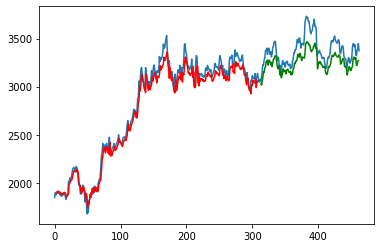

In [148]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df2)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot,color='red')
plt.plot(testPredictPlot,color='green')
plt.show()

In [149]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print("Root mean square error = ",trainScore," RMSE")
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Root mean square error = ",testScore," RMSE")

Root mean square error =  81.14605162770795  RMSE
Root mean square error =  138.73061634472873  RMSE


<hr>

### Step 6 : Creating a Hybrid model for Numerical and Textual Analysis

> Merging News Headlines Data with Yahoo Finance Stock Data.
> * Doing sentimental analysis of news on basis of change in yahoo finance stock prices.
> > Predicting Stock Price "Close" Factor on basis of news headlines -> Subjectivity,Polarity,Compound,Negative,Neutral,Positive

In [254]:
# Set the start and end date
start_date = '2008-08-08'
end_date = '2016-07-01'

# Set the ticker
ticker = 'AMZN'

# Get the data
df = yf.download(ticker, start_date, end_date)

# Print 5 rows
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-24,693.000000,712.530029,692.200012,698.960022,698.960022,7632500
2016-06-27,692.010010,696.820007,682.119995,691.359985,691.359985,5568000
2016-06-28,700.000000,708.000000,698.169983,707.950012,707.950012,4037000
2016-06-29,715.750000,719.500000,713.539978,715.599976,715.599976,3070100
2016-06-30,717.200012,719.369995,712.539978,715.619995,715.619995,2855100


In [255]:
df.to_csv("YahooFinance_Sensex_2008-2016.csv")

In [306]:
#Text Analysis
news =pd.read_csv('csv/News.csv',index_col='Date')
sensex = pd.read_csv('csv/YahooFinance_Sensex_2008-2016.csv',index_col='Date')

In [307]:
news.tail() 
#Label 0= Down
#Label 1= Up

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-27,0,Barclays and RBS shares suspended from trading...,Pope says Church should ask forgiveness from g...,Poland 'shocked' by xenophobic abuse of Poles ...,"There will be no second referendum, cabinet ag...","Scotland welcome to join EU, Merkel ally says",Sterling dips below Friday's 31-year low amid ...,No negative news about South African President...,Surge in Hate Crimes in the U.K. Following U.K...,Weapons shipped into Jordan by the CIA and Sau...,...,German lawyers to probe Erdogan over alleged w...,"Boris Johnson says the UK will continue to ""in...",Richard Branson is calling on the UK governmen...,Turkey 'sorry for downing Russian jet',Edward Snowden lawyer vows new push for pardon...,Brexit opinion poll reveals majority don't wan...,"Conservative MP Leave Campaigner: ""The leave c...","Economists predict UK recession, further weake...","New EU 'superstate plan by France, Germany: Cr...",Pakistani clerics declare transgender marriage...
2016-06-28,1,"2,500 Scientists To Australia: If You Want To ...","The personal details of 112,000 French police ...",S&amp;P cuts United Kingdom sovereign credit r...,Huge helium deposit found in Africa,CEO of the South African state broadcaster qui...,"Brexit cost investors $2 trillion, the worst o...",Hong Kong democracy activists call for return ...,Brexit: Iceland president says UK can join 'tr...,UK's Osborne: 'Absolutely' going to have to cu...,...,"US, Canada and Mexico pledge 50% of power from...",There is increasing evidence that Australia is...,"Richard Branson, the founder of Virgin Group, ...","37,000-yr-old skull from Borneo reveals surpri...",Palestinians stone Western Wall worshipers; po...,Jean-Claude Juncker asks Farage: Why are you h...,"""Romanians for Remainians"" offering a new home...",Brexit: Gibraltar in talks with Scotland to st...,8 Suicide Bombers Strike Lebanon,Mexico's security forces routinely use 'sexual...
2016-06-29,1,Explosion At Airport In Istanbul,Yemeni former president: Terrorism is the offs...,UK must accept freedom of movement to access E...,Devastated: scientists too late to captive bre...,British Labor Party leader Jeremy Corbyn loses...,A Muslim Shop in the UK Was Just Firebombed Wh...,Mexican Authorities Sexually Torture Women in ...,UK shares and pound continue to recover,Iceland historian Johannesson wins presidentia...,...,"Escape Tunnel, Dug by Hand, Is Found at Holoca...",The land under Beijing is sinking by as much a...,Car bomb and Anti-Islamic attack on Mosque in ...,Emaciated lions in Taiz Zoo are trapped in blo...,Rupert Murdoch describes Brexit as 'wonderful'...,More than 40 killed in Yemen suicide attacks,Google Found Disastrous Symantec and Norton Vu...,Extremist violence on the rise in Germany: Dom...,BBC News: Labour MPs pass Corbyn no-confidence...,Tiny New Zealand town with 'too many jobs' lau...
2016-06-30,1,Jamaica proposes marijuana dispensers for tour...,Stephen Hawking says pollution and 'stupidity'...,Boris Johnson says he will not run for Tory pa...,Six gay men in Ivory Coast were abused and for...,Switzerland denies citizenship to Muslim immig...,Palestinian terrorist stabs israeli teen girl ...,Puerto Rico will default on $1 billion of debt...,Republic of Ireland fans to be awarded medal f...,Afghan suicide bomber 'kills up to 40' - BBC News,...,Googles free wifi at Indian railway stations i...,Mounting evidence suggests 'hobbits' were wipe...,The men who carried out Tuesday's terror attac...,Calls to suspend Saudi Arabia from UN Human Ri...,More Than 100 Nobel Laureates Call Out Greenpe...,British pedophile sentenced to 85 years in US ...,"US permitted 1,200 offshore fracks in Gulf of ...",We will be swimming in ridicule - French beach...,UEFA says no minutes of silence for Istanbul v...,Law Enforcement Sources: Gun Used in Paris Ter...
2016-07-01,1,A 117-year-old woman 

In [308]:
sensex.head() #Sensex data values

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-08-07,77.010002,78.050003,76.000000,76.949997,76.949997,5444800
2008-08-08,76.779999,81.209999,76.290001,80.510002,80.510002,9162700
2008-08-11,80.180000,91.750000,79.779999,88.089996,88.089996,25070200
2008-08-12,87.320000,88.480003,86.099998,87.250000,87.250000,8026500
2008-08-13,86.279999,88.250000,84.540001,86.690002,86.690002,7208800


In [309]:
news.shape , sensex.shape

((1989, 26), (1989, 6))

In [317]:
merge = pd.merge(news, sensex, how = 'inner', right_index = True, left_index = True)
merge

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top22,Top23,Top24,Top25,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",76.779999,81.209999,76.290001,80.510002,80.510002,9162700
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",80.180000,91.750000,79.779999,88.089996,88.089996,25070200
2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",...,b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",87.320000,88.480003,86.099998,87.250000,87.250000,8026500
2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',"b""The commander of a Navy air reconnaissance s...",...,b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,86.279999,88.250000,84.540001,86.690002,86.690002,7208800
2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",b'Russia exaggerating South Ossetian death tol...,...,b'Taliban wages war on humanitarian aid workers',"b'Russia: World ""can forget about"" Georgia\'s...",b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...,85.709999,88.750000,85.220001,88.029999,88.029999,6901700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-24,0,David Cameron to Resign as PM After EU Referendum,BBC forecasts UK votes to Leave the European U...,Nicola Sturgeon says a second independence ref...,It's official

In [340]:
merge = merge.reset_index()

In [341]:
merge

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [342]:
#Combine all news headlines into one column
headlines =[]
 
for row in range(0, len(merge.index)):
    headlines.append(''.join(str(x) for x in merge.iloc[row, 2:27]))

In [343]:
headlines[0] # similarly all headlines are converted

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war"b\'BREAKING: Musharraf to be impeached.\'b\'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\'b\'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\'b"Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing"b\'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\'b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side"b"The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it."b\'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]\'b\'Did the U.S. Prep Georgia for War with Russia?\'b\'Rice G

<hr>

### Step 7 : Text preprocessing

>  Cleaning the text data and make it ready to feed data to the model. Text data contains noise in various forms like emotions, punctuation, text in a different case.

In [344]:
#Preprocess this data to obtain better accuracy
preprocessed_headlines=[]

for i in range(0,len(headlines)):
    preprocessed_headlines.append(re.sub("b[(')]",'', headlines[i]))
    preprocessed_headlines[i] = re.sub('b[(")]','', preprocessed_headlines[i])
    preprocessed_headlines[i]=re.sub("\'",'',preprocessed_headlines[i])

In [345]:
preprocessed_headlines[0] #cleaned dataset

'Georgia downs two Russian warplanes as countries move to brink of war"BREAKING: Musharraf to be impeached.Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fireAfghan children raped with impunity, U.N. official says - this is sick, a three year old was raped and they do nothing"150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SOs side"The enemy combatent trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it."Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]Did the U.S. Prep Georgia for War with Russia?Rice Gives Green Light for Israel to Attack Iran: Says U.S. h

In [346]:
#merge the preprocessed headlines to the original dataset
merge['Combined_News'] = preprocessed_headlines
merge

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Combined_News
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",Georgia downs two Russian warplanes as countri...
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",Why wont America and Nato help us? If they won...
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",Remember that adorable 9-year-old who sang at ...
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,U.S. refuses Israel weapons to attack Iran: r...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P

<hr>

### Step 8 : Adding subjectivity and polarity Scores

> TextBlob Sentiment: Calculating Polarity and Subjectivity
>> The TextBlob package for Python is a convenient way to do a lot of Natural Language Processing (NLP) tasks. For example:

<i>from textblob import TextBlob <br>
TextBlob("not a very great calculation").sentiment</i>
#### Output: Sentiment(polarity=-0.3076923076923077, subjectivity=0.5769230769230769)
>> This tells us that the English phrase “not a very great calculation” has a polarity of about -0.3, meaning it is slightly negative, and a subjectivity of about 0.6, meaning it is fairly subjective.

In [347]:
#Function to get Polarity and Subjectivity
#Polarity 1:- Positive
#Polarity 0:- Negative
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [348]:
#Add two new columns to the merged dataset
merge['Subjectivity']= merge['Combined_News'].apply(getSubjectivity)
merge['Polarity']= merge['Combined_News'].apply(getPolarity)

In [349]:
merge.head(5)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Combined_News,Subjectivity,Polarity
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",Georgia downs two Russian warplanes as countri...,0.277104,-0.050303
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",Why wont America and Nato help us? If they won...,0.365960,0.082481
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,"b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",Remember that adorable 9-year-old who sang at ...,0.536257,-0.058650
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,"b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,U.S. refuses Israel weapons to attack Iran: r...,0.353922,-0.004739
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,"b'""Non-media"" photos of South Ossetia/Georgia ...",b'Georgian TV reporter shot by Russian sniper ...,b'Saudi Arabia: Mother moves to block child ma...,b'Taliban wages war on humanitari

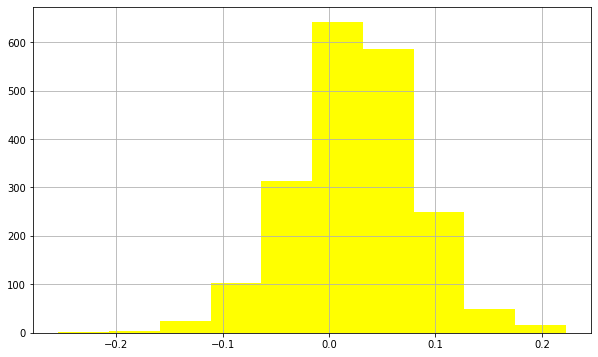

In [350]:
plt.figure(figsize = (10,6))
merge['Polarity'].hist(color = 'yellow')

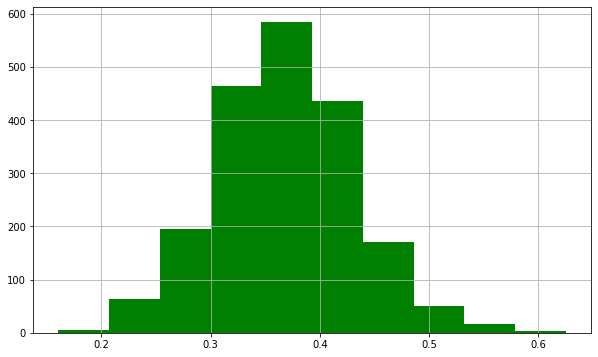

In [351]:
plt.figure(figsize = (10,6))
merge['Subjectivity'].hist(color = 'green')

<hr>

### Step 10 : Performing Sentiment Analysis over the news Headlines

In [352]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [353]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid= SentimentIntensityAnalyzer()

In [354]:
merge['score']= merge['Combined_News'].apply(lambda Combined_News : sid.polarity_scores(Combined_News))

In [355]:
merge.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top20,Top21,Top22,Top23,Top24,Top25,Combined_News,Subjectivity,Polarity,score
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",Georgia downs two Russian warplanes as countri...,0.277104,-0.050303,"{'neg': 0.214, 'neu': 0.724, 'pos': 0.062, 'co..."
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",Why wont America and Nato help us? If they won...,0.365960,0.082481,"{'neg': 0.148, 'neu': 0.761, 'pos': 0.091, 'co..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",Remember that adorable 9-year-old who sang at ...,0.536257,-0.058650,"{'neg': 0.139, 'neu': 0.805, 'pos': 0.056, 'co..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,U.S. refuses Israel weapons to attack Iran: r...,0.353922,-0.004739,"{'neg': 0.146, 'neu': 0.797, 'pos': 0.058, 'co..."
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,b'Georgian TV reporter shot by Russian sniper ...,b'Saudi Arabia: Mother moves to block child ma...,b'Taliban wages war on humanitarian aid workers',"b'Russia: World ""can f

In [356]:
merge['Compound']= merge['score'].apply(lambda score_dict: score_dict['compound'])
merge['Positive']= merge['score'].apply(lambda score_dict: score_dict['pos'])
merge['Negative']= merge['score'].apply(lambda score_dict: score_dict['compound'])
merge['Neutral']= merge['score'].apply(lambda score_dict: score_dict['neu'])
merge.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top24,Top25,Combined_News,Subjectivity,Polarity,score,Compound,Positive,Negative,Neutral
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",Georgia downs two Russian warplanes as countri...,0.277104,-0.050303,"{'neg': 0.214, 'neu': 0.724, 'pos': 0.062, 'co...",-0.9966,0.062,-0.9966,0.724
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",Why wont America and Nato help us? If they won...,0.365960,0.082481,"{'neg': 0.148, 'neu': 0.761, 'pos': 0.091, 'co...",-0.9457,0.091,-0.9457,0.761
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",Remember that adorable 9-year-old who sang at ...,0.536257,-0.058650,"{'neg': 0.139, 'neu': 0.805, 'pos': 0.056, 'co...",-0.9739,0.056,-0.9739,0.805
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,U.S. refuses Israel weapons to attack Iran: r...,0.353922,-0.004739,"{'neg': 0.146, 'neu': 0.797, 'pos': 0.058, 'co...",-0.9805,0.058,-0.9805,0.797
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...,All the experts admit that we should legalise ...,0.384127,0.026930,"{'neg': 0.185, 'neu': 0.723, 'pos': 0.092, 'co...",-0.9831,0.092,-0.9831,0.723


<hr>

### Step 11 : Merging the numerical and textual data

In [358]:
#Keep necessary columns
dff = merge[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
dff

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.277104,-0.050303,-0.9966,-0.9966,0.724,0.062
1,0.365960,0.082481,-0.9457,-0.9457,0.761,0.091
2,0.536257,-0.058650,-0.9739,-0.9739,0.805,0.056
3,0.353922,-0.004739,-0.9805,-0.9805,0.797,0.058
4,0.384127,0.026930,-0.9831,-0.9831,0.723,0.092
...,...,...,...,...,...,...
1984,0.341564,-0.030999,-0.9730,-0.9730,0.754,0.090
1985,0.348121,0.039423,-0.9633,-0.9633,0.763,0.100
1986,0.406462,0.046901,-0.9962,-0.9962,0.707,0.086
1987,0.392035,-0.005811,-0.9979,-0.9979,0.727,0.058


In [362]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(dff))
new_df.columns = dff.columns
new_df.index = dff.index
new_df.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.250765,0.427836,0.001406,0.001406,0.363344,0.38750
1,0.442126,0.706426,0.026970,0.026970,0.482315,0.56875
2,0.808882,0.410322,0.012807,0.012807,0.623794,0.35000
3,0.416201,0.523433,0.009492,0.009492,0.598071,0.36250
4,0.481252,0.589876,0.008186,0.008186,0.360129,0.57500


In [368]:
X = new_df[:]
y =sensex['Close']

In [369]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(1591, 6)

In [370]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
159,0.390930,0.590744,0.002561,0.002561,0.350482,0.45625
1593,0.223088,0.531319,0.002712,0.002712,0.411576,0.48750
318,0.387035,0.604840,0.010095,0.010095,0.562701,0.52500
992,0.252807,0.463425,0.001205,0.001205,0.540193,0.21250
465,0.356542,0.379857,0.000753,0.000753,0.491961,0.27500
1460,0.257831,0.560744,0.001055,0.001055,0.263666,0.49375
251,0.472962,0.423226,0.002210,0.002210,0.366559,0.44375
1973,0.452908,0.694645,0.006127,0.006127,0.588424,0.44375
1110,0.666256,0.577974,0.003013,0.003013,0.263666,0.60625
190,0.522095,0.581199,0.012606,0.012606,0.617363,0.46875


<hr>

### Step 12 : Training a Random Forest Regressor, Adaboost Regressor, XGBoost for hybrid analysis

> Random forest regressor
> * A random forest regressor. A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. ... The number of trees in the forest.
>> Adaboost Regressor 
>> * An AdaBoost regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases.
>>> Xgboost Regressor
>>> * Regression predictive modeling problems involve predicting a numerical value such as a dollar amount or a height. XGBoost can be used directly for regression predictive modeling.

### 1. Random Forest Regressor

In [372]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
rf_pred=rf.predict(x_test)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### 2. Adaboost Regressor

In [373]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
adb_pred = adb.predict(x_test)

### 3. Xgboost Regressor

In [375]:
import xgboost

In [383]:
xgbr = xgboost.XGBRegressor()
xgbr.fit(x_train,y_train)
xgbr_Pred = xgbr.predict(x_test)

<hr>

### Step 13 : Determining the accuracy scores for these Three Models

### Random Forest Regressor

In [385]:
print(rf_pred[:10])
print(y_test[:10])
print("Root mean square error = ",math.sqrt(mean_squared_error(rf_pred,y_test))," RMSE")

[222.39300079 167.97800331 127.22700119 164.04199905 306.23099899
 255.61900406 312.93600159 386.95999832 238.27499771 118.46800156]
Date
2013-09-25    312.649994
2013-10-21    326.440002
2012-05-30    209.229996
2009-01-09     55.509998
2014-10-13    306.450012
2011-05-24    193.270004
2016-04-28    602.000000
2015-12-23    663.700012
2014-07-29    320.000000
2008-09-03     80.769997
Name: Close, dtype: float64
Root mean square error =  169.92851460577202  RMSE


### AdaBoost Regressor

In [387]:
print(adb_pred[:10])
print(y_test[:10])
print("Root mean square error = ",math.sqrt(mean_squared_error(adb_pred,y_test))," RMSE")

[335.18840591 269.30290361 163.00339426 274.37321429 254.84951263
 335.18840591 332.18999983 335.18840591 269.30290361 155.95000181]
Date
2013-09-25    312.649994
2013-10-21    326.440002
2012-05-30    209.229996
2009-01-09     55.509998
2014-10-13    306.450012
2011-05-24    193.270004
2016-04-28    602.000000
2015-12-23    663.700012
2014-07-29    320.000000
2008-09-03     80.769997
Name: Close, dtype: float64
Root mean square error =  168.74570706930987  RMSE


### XgBoost Regressor

In [388]:
print(xgbr_Pred[:10])
print(y_test[:10])
print("Root mean square error = ",math.sqrt(mean_squared_error(xgbr_Pred,y_test))," RMSE")

[301.51123  295.926     97.064    170.5492   389.6193   385.7664
 315.3773   384.2398   294.51013   74.068184]
Date
2013-09-25    312.649994
2013-10-21    326.440002
2012-05-30    209.229996
2009-01-09     55.509998
2014-10-13    306.450012
2011-05-24    193.270004
2016-04-28    602.000000
2015-12-23    663.700012
2014-07-29    320.000000
2008-09-03     80.769997
Name: Close, dtype: float64
Root mean square error =  173.33442316737705  RMSE


<hr>
<p>I have used three models, i.e., Random Forest Regressor , Adaboost Regressor and xgboost Regressor to carry out hybrid analysis. From the RMSE values we see that Adaboost & Xgboost gives slight better results.

* <strong>Note:</strong> Here , Random Forest is more underfitted, Adaboost is slightly overfitted & Xgboost is slightly underfitted.So to reduce/ prevent  Underfitting,Overfitting Problem we can also use <strong>Regularization Technique</strong> : L1 , L2 i.e. LAASO , Ridge Methods.

<strong>Hyperparameter Tunning (RandomizedSearchCV, GridSearchCV) </strong>, will also give you the best optimized models of Ensemble Learning.

However, these models have very high RMSE values. The reason for high values is the <strong>unpredictible nature of the stock prices.</strong></p>

<h1>Conclusion</h1>

> I was able to create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.
 
<h3>Thank You</h3>
<h3>Author: Dhyey Joshi</h3> 
